<a href="https://colab.research.google.com/github/NosenkoArtem/MADMO-advanced-/blob/master/week_3/%5Bseminar%5D_convnet_example_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рассмотрим сравнение сверточной сети и многослойной полносвязной для классификации MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


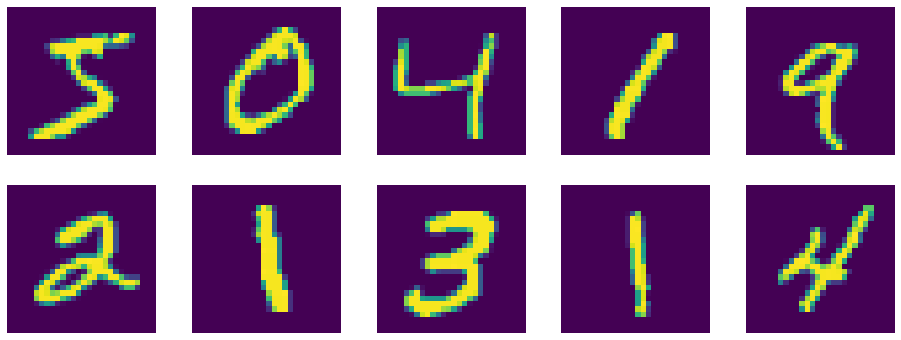

In [ ]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [ ]:
! python --version

Python 3.6.9


In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), # Wx + b
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size), # B x 10 
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        # B x 28 x 28 -> B x 28*28 
        x = x.view(-1, self.input_size)
        return self.network(x)
    

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        hidden_size = 25

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=n_feature,
                               kernel_size=5)
        
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(16*n_feature, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        ###
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
CNN(784, 10, 10)(torch.randn(3, 1, 28, 28)).size() == FC2Layer(784, 10, 10)(torch.randn(3, 1, 28, 28)).size()

True

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [ ]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        # TRAIN
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()

        # model.fc1.weights.data.grad 
        # w = w_prev + alpha* w_prev.grad
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

@torch.no_grad()
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)

        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(-1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [ ]:
n_hidden = 8 # number of hidden units
input_size=784
output_size=10
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)

print('Number of parameters: {}'.format(get_n_params(model_fnn)))
max_epochs = 2
for epoch in range(0, max_epochs):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298956
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.565634
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.199664
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.693709
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.434409
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.312587
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.410852
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.364466
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.555566
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.606113

Test set: Average loss: 0.3975, Accuracy: 8841/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.219136
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.289427
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.409445
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.287616
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.361694
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.262043
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.321497
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.587095
Train Epoch: 1 [51200/60

# Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
max_epochs = 2

for epoch in range(0, max_epochs):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 3747
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325926
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.224575
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.038589
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.363047
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.320801
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.383068
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.344014
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.416144
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.163926
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.301394

Test set: Average loss: 0.1833, Accuracy: 9432/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.294507
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.224813
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.149603
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.119768
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.131156
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.087683
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.193000
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.169889
Train Epoch: 1 [51200/60

# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images
Благодаря использованию сверточных сетей мы получаем качество значительно лучше, но почему это происходит? Мы изначально заложили в свертки гипотезу о локльности (схожие пиксели находятся рядом друг с другом)

# Эксперимент: что если эта гипотеза не выполняется? 


In [ ]:
perm = torch.randperm(784)


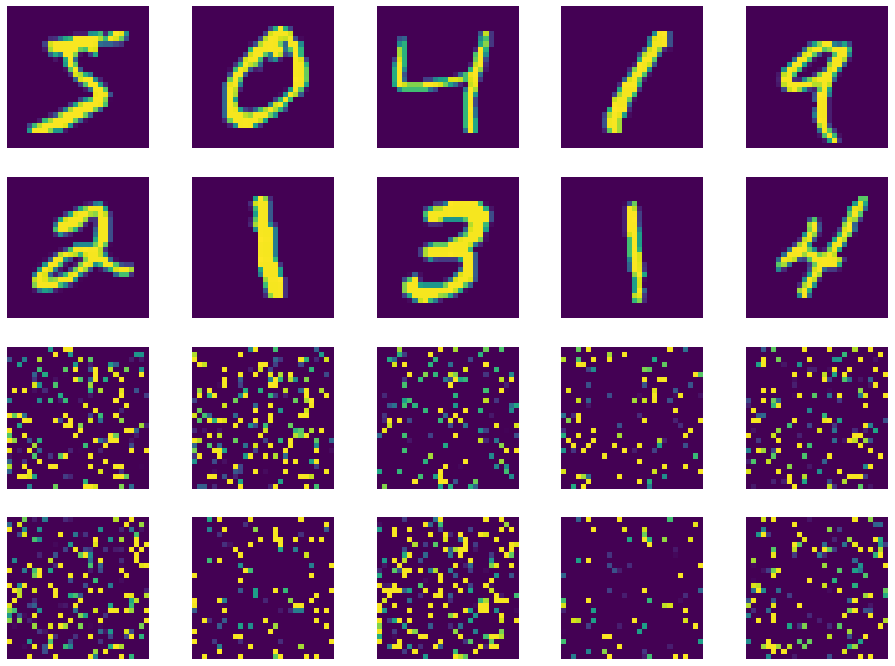

In [ ]:
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))
max_epochs = 2

for epoch in range(max_epochs):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 3747
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312147
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.254741
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.149557
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.815868
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.597029
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.493571
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.071556
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.709387
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.964937
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.726995

Test set: Average loss: 0.6741, Accuracy: 7812/10000 (78%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.695981
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.463446
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.597682
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.397416
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.299709
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.352011
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.328488
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.433946
Train Epoch: 1 [51200/60

# Fully-Connected with Permuted Pixels

In [ ]:
n_hidden = 8 # number of hidden units
input_size=784
output_size=10
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(max_epochs):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303867
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.641740
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.286576
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.942272
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.549672
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.440537
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.391334
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.400791
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.531044
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.550906

Test set: Average loss: 0.3840, Accuracy: 8895/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.678375
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.372831
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.214754
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.331933
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.308686
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.252702
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.185700
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.429380
Train Epoch: 1 [51200/60

### The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

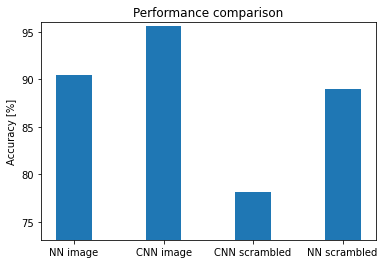

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list[-8::2], width=0.4)
plt.ylim((min(accuracy_list[-8::2])-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');